In [1]:
import warnings
warnings.filterwarnings("ignore")

# 1 - Overview

Twitter is a mix of social network and microblogging. In this network, people post information and communicate among themselves through messages, called tweets, that can contain up to 280 characters. In this assignment, *we will implement a prototype that can detect if an airline company is positively or negatively mentioned in a tweet*. 



# 2 - Sentiment Analysis Model (13 points)

In the literature, the task of extracting the sentiment of a text is called *sentiment analysis*. We will implement a bag-of-words (BoW) model for this task.

## 2.1 -  Setup

Please run the code below to install the packages needed for this assignment.

In [2]:
# Install a pip package in the current Jupyter kernel
import sys


In [3]:
# If you want, you can use anaconda and install after nltk library
# pip install --user numpy
# pip install --user sklearn
# pip install --user scipy
# pip install --user nltk

# python
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")


[nltk_data] Downloading package punkt to /home/quentin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/quentin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/quentin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/quentin/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## 2.2 - Dataset

Please download the zip file in the following url: https://drive.google.com/file/d/1iGmESwPXpO3sIZFGOCrysxJ27AHdly-Y/view?usp=sharing

In this zip file, there are 2 files:
1. train.tsv: training dataset
2. dev.tsv: validation dataset

Each line of the files has the following information about a tweet: *tweet id*, *user id*, *label* and *message text*.

There are three labels in the dataset: *negative*, *neutral* and *positive*. We represent each one of these labels as 0, 1 and 2 respectively.

In the code above read the training and validation datasets.

In [4]:
import codecs
import re


def load_dataset(path):
    dtFile = codecs.open(path, "r")

    x = []
    y = []

    for l in dtFile:
        sid, uid, label, text = re.split(r"\s+", l, maxsplit=3)

        text = text.strip()

        # Remove not available
        if text == "Not Available":
            continue

        x.append(text)

        if label == "negative":
            y.append(0)
        elif label == "neutral":
            y.append(1)
        elif label == "positive":
            y.append(2)

    assert len(x) == len(y)

    return x, y


# Path of training dataset
trainingPath = "data/train_data.tsv"

# Path of validation dataset
validationPath = "data/dev_data.tsv"

training_X, training_Y = load_dataset(trainingPath)
validation_X, validation_Y = load_dataset(validationPath)


## 2.3 - Preprocessing

Preprocessing is a crucial task in data mining. This task clean and transform the raw data in a format that can better suit data analysis and machine learning techniques. In natural language processing (NLP), *tokenization* and *stemming* are two well known preprocessing steps. Besides these two steps, we will implement an additional step that is designed exclusively for the twitter domain.

### 2.3.1 - Tokenization

In this preprocessing step, a *tokenizer* is responsible for breaking a text in a sequence of tokens (words, symbols, and punctuations). For instance, the sentence *"It's the student's notebook."* can be split into the following list of tokens: ['It', "'s", 'the', 'student', "'s", 'notebook', '.'].


#### 2.3.1.1 - Question 1 (0.5 point) 

Implement the SpaceTokenizer and NLTKTokenizer tokenizers: 
- **SpaceTokenizer** tokenizes the tokens that are separated by whitespace (space, tab, newline). This is a naive tokenizer.
- **NLTKTokenizer** uses the default method of the nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.

**All tokenizers have to lowercase the tokens.**

In [5]:
from nltk.tokenize import TweetTokenizer


class SpaceTokenizer(object):
    """
    It tokenizes the tokens that are separated by whitespace (space, tab, newline). 
    We consider that any tokenization was applied in the text when we use this tokenizer.

    For example: "hello\tworld of\nNLP" is split in ['hello', 'world', 'of', 'NLP']
    """

    def tokenize(self, text):
        # Write your code here

        # Have to return a list of tokens
        return text.split()


class NLTKTokenizer(object):
    """
    This tokenizer uses the default function of nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.
    """

    def tokenize(self, text):
        # Write your code here

        tknzr = TweetTokenizer()

        # Have to return a list of tokens
        return tknzr.tokenize(text)


##### Test of the 2 tokenizers:

In [6]:
ST = SpaceTokenizer()
print(ST.tokenize("hello\tworld of\nNLP!!!"))

NLTKT = NLTKTokenizer()
print(NLTKT.tokenize("hello\tworld of\nNLP!!!"))


['hello', 'world', 'of', 'NLP!!!']
['hello', 'world', 'of', 'NLP', '!', '!', '!']


### 2.3.2 - Stemming

In the tweets *"I should have bought a new shoes today"* and *"I spent too much money buying games"*, the words *"buy"* and *"bought"* represent basically the same concept. Considering both words as different can unnecessarily increase the dimensionality of the problem and can negatively impact the performance of simple models. Therefore, a unique form (e.g., the root buy) can represent both words. The process to convert words with the same stem (word reduction that keeps word prefixes) to a standard form is called *stemming*.

#### 2.3.2.1 - Question 2 (0.5 point) 

Retrieve the stems of the tokens using the attribute *stemmer* from the class *Stemmer*.

In [7]:
from nltk.stem.snowball import SnowballStemmer


class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)

    def stem(self, tokens):
        """
        tokens: a list of strings
        """
        # Have to return a list of stems
        return self.stemmer.stem(tokens)


##### Test on an example:

In [8]:
tweet = "I buy a car, he buys at http://google.com !!!"
tokens = NLTKTokenizer().tokenize(tweet)
tokens = list(map(Stemmer().stem, tokens))
print(tokens)

['i', 'buy', 'a', 'car', ',', 'he', 'buy', 'at', 'http://google.com', '!', '!', '!']


### 2.3.3 - Twitter preprocessing

Sometimes only applying the default NLP preprocessing steps is not enough. Data for certain domains can have peculiar characteristics which requires specific preprocessing steps to remove the noise and create a more suitable format for the models. 

In NLP, methods store a set of words, called dictionary, and all the words out of the dictionary are considered as unknown. In this assignment, the feature space dimensionality of a model is directly related to the number of words in the dictionary. Since high-dimensional spaces can suffer from the curse of dimensionality, our goal is to create preprocessing steps that decrease vocabulary size.  

#### 2.3.3.1 - Question 3 (2.0 points)

Briefly explain and implement at least two preprocessing steps that reduce the dictionary size (number of unique words). These preprocessing steps must be related to the specific characteristic of the Twitter data. Therefore, for instance, the stop words removal will not be accepted as a preprocessing step.

##### Here are the preprocessing steps we implement:

* Remove links and url : most of the time, a link has no semantic meaning, so we can delete them without losing a lot of informations about the sentiment of tweet, and this can reduce a lot the vocabulary size.

* Remove numbers : all the numbers, and more generally all the tokens that contains numbers (for example hours) can be removed.

* Remove # (keep words) : on Twitter, we can add an "#" in front of a word to do a hashtag: we can delete the # in front of the word.

* Remove punctuations : to keep only the words

In [9]:
import string


class TwitterPreprocessing(object):

    def preprocess(self, tweet):
        """
        tweet: original tweet
        """
        new_tweet = []
        # Write your preprocessing steps here.
        for word in tweet:
            # remove punctuation
            if any(c in string.punctuation for c in word):
                continue
            # remove url and username
            if '@' in word or 'http' in word:
                continue
            # remove word if digit inside
            if any(letter.isdigit() for letter in word):
                continue
            # check if empty
            if not word.strip():
                continue
            new_tweet.append(word.replace('#', ''))

        # return the preprocessed twitter
        return new_tweet


In [10]:
tweet = "I buy a car, he buys at http://google.com !!!"
tokens = NLTKTokenizer().tokenize(tweet)
tokens = list(map(Stemmer().stem, tokens))
tokens = TwitterPreprocessing().preprocess(tokens)
print(tokens)

['i', 'buy', 'a', 'car', 'he', 'buy', 'at']


### 2.3.3  Pipeline

The pipeline is sequence of preprocessing steps that transform the raw data to a format that is suitable for your problem. We implement the class *PreprocessingPipeline* that apply the tokenizer, twitter preprocessing and stemer to the text.

**Feel free to change the preprocessing order.**

In [11]:
class PreprocessingPipeline:

    def __init__(self, tokenization, twitterPreprocessing, stemming):
        """
        tokenization: enable or disable tokenization.
        twitterPreprocessing: enable or disable twitter preprocessing.
        stemming: enable or disable stemming.
        """

        self.tokenizer = NLTKTokenizer() if tokenization else SpaceTokenizer()
        self.twitterPreprocesser = TwitterPreprocessing(
        ) if twitterPreprocessing else None
        self.stemmer = Stemmer() if stemming else None

    def preprocess(self, tweet):
        """
        Transform the raw data

        tokenization: boolean value.
        twitterPreprocessing: boolean value. Apply the
        stemming: boolean value.
        """

        tokens = self.tokenizer.tokenize(tweet)

        if self.stemmer:
            tokens = list(map(self.stemmer.stem, tokens))

        if self.twitterPreprocesser:
            tokens = self.twitterPreprocesser.preprocess(tokens)

        return tokens


In [12]:
pipeline = PreprocessingPipeline(tokenization=True, twitterPreprocessing=True, stemming=True)
print(list(map(pipeline.preprocess, training_X[:1])))

[['gas', 'by', 'my', 'hous', 'hit', 'go', 'to', 'chapel', 'hill', 'on', 'sat']]


## 2.4 N-grams

An n-gram is a contiguous sequence of *n* tokens from a text. Thus, for instance,the sequence *"bye as"* and *"walked through"* are example of 2-grams from the sentence *"He said bye as he walked through the door ."*. 1-gram, 2-gram and 3-gram are, respectively, called unigram, bigram and trigram. We list all the possible unigram, bigram and trigram from the *"He said bye as he walked through the door ."*:

- Unigram: ["He", "said", "bye", "as", "he", "walked", "through", "the", "door", "."]
- Bigram: ["He said", "said bye", "bye as", "as he", "he walked", "walked through", "through the", "the door", "door ."] 
- Trigram: ["He said bye", "said bye as", "bye as he", "as he walked", "he walked through", "walked through the", "through the door", "the door ."] 


### 2.4.1 - Question 4 (1 point)

Implement bigram and trigram.

**For this exercise, you cannot use any external python library (e.g., scikit-learn).**

In [13]:
def bigram(tokens):
    """
    tokens: a list of strings
    """
    # Write your code here
    # This function returns the list of bigrams
    return [" ".join(tokens[i:i + 2]) for i in range(len(tokens) - 1)]


def trigram(tokens):
    """
    tokens: a list of strings
    """
    # Write your code here
    # This function returns the list of trigrams
    return [" ".join(tokens[i:i + 3]) for i in range(len(tokens) - 2)]


## 2.5 Bag-of-words

Logistic regression, SVM and other well-known models only accept inputs that have the same size. However, there are some data types whose sizes are not fixed, for instance, a text can have an unlimited number of words. Imagine that we retrieve two tweets: ”Board games are much better than video games” and ”Pandemic is an awesome game!”. These sentences are respectively named as Sentence 1 and 2. Table below depicts how we could represent both sentences using a fixed representation.

Each column of this table 2.1 represents one of 13 vocabulary words, whereas the rows contains the word
frequencies in each sentence. For instance, the cell in row 1 and column 7 has the value 2
because the word games occurs twice in Sentence 1. Since the rows have always 13 values, we
could use those vectors to represent the Sentences 1 and 2. The table above illustrates a technique called bag-of-words. Bag-of-words represents a document as a vector whose dimensions are equal to the number of times that vocabulary words appeared in the document. Thus, each token will be related to a dimension, i.e., an integer.

### 2.5.1 - Question 5 (2 points)

Implement the bag-of-words model that weights the vector with the absolute word frequency.

**For this exercise, you cannot use any external python library (e.g., scikit-learn). However, if you have a problem with memory size, you can use the class scipy.sparse.csr_matrix (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html)
**

In [14]:
from scipy.sparse import csr_matrix


class CountBoW(object):

    def __init__(self, pipeline, bigram=False, trigram=False):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.words = None

    def fit_transform(self, X):
        """
        This method preprocesses the data using the pipeline object, relates each unigram, bigram or trigram to a specific integer and  
        transforms the text in a vector. Vectors are weighted using the token frequencies in the sentence.
        
        X: a list that contains tweet contents
        
        :return: a list of vectors
        """
        X = list(map(self.pipeline.preprocess, X))
        if self.bigram:
            for tweet in X:
                tweet += bigram(tweet)
        if self.trigram:
            for tweet in X:
                tweet += trigram(tweet)
        N = len(X)

        # list of all words
        self.words = list(set((word for tweet in X for word in tweet)))

        data, row, col = [], [], []
        for i, tweet in enumerate(X):
#             print("\r{}/{}".format(i, N), end="")
            for word in tweet:
                data.append(tweet.count(word))
                row.append(i)
                col.append(self.words.index(word))

        return csr_matrix((data, (row, col)), shape=(N, len(self.words)))

    def transform(self, X):
        """
        This method preprocesses the data using the pipeline object and  transforms the text in a list of integer.
        Vectors are weighted using the token frequencies in the sentence.

        X: a list of vectors

        :return: a list of vectors
        """
        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )

        X = list(map(self.pipeline.preprocess, X))
        if self.bigram:
            for tweet in X:
                tweet += bigram(tweet)
        if self.trigram:
            for tweet in X:
                tweet += trigram(tweet)
        N = len(X)

        data, row, col = [], [], []
        for i, tweet in enumerate(X):
            for word in tweet:
                if word in self.words:
                    data.append(tweet.count(word))
                    row.append(i)
                    col.append(self.words.index(word))

        return csr_matrix((data, (row, col)), shape=(N, len(self.words)))


### 2.5.2 - TF-IDF

Using raw frequency in the bag-of-words can be problematic. The word frequency distribution
is skewed - only a few words have high frequencies in a document. Consequently, the
weight of these words will be much bigger than the other ones which can give them more
impact on some tasks, like similarity comparison. Besides that, a set of words (including
those with high frequency) appears in most of the documents and, therefore, they do not
help to discriminate documents. For instance, the word *of* appears in a significant
part of tweets. Thus, having the word *of* does not make
documents more or less similar. However, the word *terrible* is rarer and documents that
have this word are more likely to be negative. TF-IDF is a technique that overcomes the word frequency disadvantages.

TF-IDF weights the vector using inverse document frequency (IDF) and word frequency, called term frequency (TF).
TF is the local information about how important is a word to a specific document.  IDF measures the discrimination level of the words in a dataset.  Common words in a domain are not helpful to discriminate documents since most of them contain these terms. So, to reduce their relevance in the documents, these words should have low weights in the vectors . 
The following equation calculates the word IDF:
\begin{equation}
	idf_i = \log\left( \frac{N}{df_i} \right),
\end{equation}
where $N$ is the number of documents in the dataset, $df_i$ is the number of documents that contain a word $i$.
The new weight $w_{ij}$ of a word $i$ in a document $j$ using TF-IDF is computed as:
\begin{equation}
	w_{ij} = tf_{ij} \times idf_i,
\end{equation}
where $tf_{ij}$ is the term frequency of word $i$ in the document $j$.




### 2.5.2.1 - Question 6 (3 points)

Implement a bag-of-words model that weights the vector using TF-IDF.

**For this exercise, you cannot use any external python library (e.g., scikit-learn). However, if you have a problem with memory size, you can use the class scipy.sparse.csr_matrix (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html)**

In [15]:
from scipy.sparse import csr_matrix
import math


class TFIDFBoW(object):

    def __init__(self, pipeline, bigram=False, trigram=False):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.words = None

    def fit_transform(self, X):
        """
        This method preprocesses the data using the pipeline object, calculates the IDF and TF and 
        transforms the text in vectors. Vectors are weighted using TF-IDF method.
        
        X: a list that contains tweet contents
        
        :return: a list that contains the list of integers
        """
        X = list(map(self.pipeline.preprocess, X))
        if self.bigram:
            for tweet in X:
                tweet += bigram(tweet)
        if self.trigram:
            for tweet in X:
                tweet += trigram(tweet)
        N = len(X)

        # list of all words
        self.words = list(set((word for tweet in X for word in tweet)))

        # compute idf
        self.idf = []
        for word in self.words:
            count = sum([word in tweet for tweet in X])
            self.idf.append(math.log(N / count))

        data, row, col = [], [], []
        for i, tweet in enumerate(X):
            for word in set(tweet):
                data.append(tweet.count(word) * self.idf[i])
                row.append(i)
                col.append(self.words.index(word))

        return csr_matrix((data, (row, col)), shape=(N, len(self.words)))

    def transform(self, X):
        """
        This method preprocesses the data using the pipeline object and  
            transforms the text in a list of integer.
        """

        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )

        X = list(map(self.pipeline.preprocess, X))
        if self.bigram:
            for tweet in X:
                tweet += bigram(tweet)
        if self.trigram:
            for tweet in X:
                tweet += trigram(tweet)
        N = len(X)

        data, row, col = [], [], []
        for i, tweet in enumerate(X):
            for word in set(tweet):
                if word in self.words:
                    data.append(tweet.count(word) * self.idf[i])
                    row.append(i)
                    col.append(self.words.index(word))

        return csr_matrix((data, (row, col)), shape=(N, len(self.words)))


## 2.6 - Classifier using BoW

We are going to use logistic regression as a classifier. Read the following page to now more about this classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


The method *train_evaluate* trains and evaluates the logistic regression model.

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


def train_evaluate(training_X, training_Y, validation_X, validation_Y, bowObj):
    """
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset
    bowObj: Bag-of-word object
    
    :return: the classifier and its accuracy in the training and validation dataset.
    """

    classifier = LogisticRegression(n_jobs=-1)

    training_rep = bowObj.fit_transform(training_X)

    classifier.fit(training_rep, training_Y)

    trainAcc = accuracy_score(training_Y, classifier.predict(training_rep))
    validationAcc = accuracy_score(
        validation_Y, classifier.predict(bowObj.transform(validation_X)))

    return classifier, trainAcc, validationAcc



### 2.6.1 - Question 7 (4 points)

Train and calculate the logistic regression accuracy in the *training and validation dataset* using each one of the following configurations:
    1. CountBoW + SpaceTokenizer(without tokenizer) + unigram 
    2. CountBoW + NLTKTokenizer + unigram
    3. TFIDFBoW + NLTKTokenizer + Stemming + unigram
    4. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram
    5. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram
    6. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram + trigram
Besides the accuracy, you have to report the dictionary size for each one of configurations. Finally, describe the results found by you and answer the following questions:
- Which preprocessing has helped the model? Why?
- TF-IDF has achieved a better performance than CountBoW? If yes, why do you think that this has occurred? 
- Has the bigram and trigram improved the performance? If yes, can you mention the reasons of this improvement?

In [17]:
print("{:10}: {:^10} {:^10}".format("Experience", "trainAcc", "validAcc"))
# 1. CountBoW + SpaceTokenizer(without tokenizer) + unigram
bowObj = CountBoW(
    PreprocessingPipeline(
        tokenization=False, twitterPreprocessing=False, stemming=False))
_, trainAcc, validAcc = train_evaluate(training_X, training_Y, validation_X,
                                       validation_Y, bowObj)
print("{:10}: {:^10.3%} {:^10.3%}".format(1, trainAcc, validAcc))

# 2. CountBoW + NLTKTokenizer + unigram
bowObj = CountBoW(
    PreprocessingPipeline(
        tokenization=True, twitterPreprocessing=False, stemming=False))
_, trainAcc, validAcc = train_evaluate(training_X, training_Y, validation_X,
                                       validation_Y, bowObj)
print("{:10}: {:^10.3%} {:^10.3%}".format(2, trainAcc, validAcc))

# 3. TFIDFBoW + NLTKTokenizer + Stemming + unigram
bowObj = TFIDFBoW(
    PreprocessingPipeline(
        tokenization=True, twitterPreprocessing=False, stemming=True))
_, trainAcc, validAcc = train_evaluate(training_X, training_Y, validation_X,
                                       validation_Y, bowObj)
print("{:10}: {:^10.3%} {:^10.3%}".format(3, trainAcc, validAcc))

# 4. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram
bowObj = TFIDFBoW(
    PreprocessingPipeline(
        tokenization=True, twitterPreprocessing=True, stemming=True))
_, trainAcc, validAcc = train_evaluate(training_X, training_Y, validation_X,
                                       validation_Y, bowObj)
print("{:10}: {:^10.3%} {:^10.3%}".format(4, trainAcc, validAcc))

# 5. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram
bowObj = TFIDFBoW(
    PreprocessingPipeline(
        tokenization=True, twitterPreprocessing=True, stemming=True),
    bigram=True)
_, trainAcc, validAcc = train_evaluate(training_X, training_Y, validation_X,
                                       validation_Y, bowObj)
print("{:10}: {:^10.3%} {:^10.3%}".format(5, trainAcc, validAcc))

# 6. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram + trigram
bowObj = TFIDFBoW(
    PreprocessingPipeline(
        tokenization=True, twitterPreprocessing=True, stemming=True),
    bigram=True,
    trigram=True)
_, trainAcc, validAcc = train_evaluate(training_X, training_Y, validation_X,
                                       validation_Y, bowObj)
print("{:10}: {:^10.3%} {:^10.3%}".format(6, trainAcc, validAcc))


Experience:  trainAcc   validAcc 
         1:  99.545%    59.312%  
         2:  99.076%    62.489%  
         3:  99.927%    63.107%  
         4:  99.795%    58.694%  
         5:  99.853%    60.989%  
         6:  99.853%    61.430%  


Generally, for all the models, we can see that our model overfits on the training set, as we have more than 99% of accuracy. More precisely : 

* The configuration 2 is better than the 1, so NLTKTokenizer is a better tokenizer for our problem (better than the naive one)

* Adding stemming allows to improve a tiny bit the accuracy (configuration 3 better than the 2).

* TF-IDF has achieved a better performance than CountBoW. This is probably because we have to keep some words that don't appear a lot of times but give a lot of information about the sentiment of tweets.

* With this results, we can see that the 3rd configuration is the best one (best validation accuracy), adding the Twitter preprocessing, and the N-grams don't help for the prediction. This may be because we overfit already, so adding informations with N-grams is not necessary.


### Model chosen : the 3rd one

In [18]:
# 3. TFIDFBoW + NLTKTokenizer + Stemming + unigram
bowObj = TFIDFBoW(
    PreprocessingPipeline(
        tokenization=True, twitterPreprocessing=False, stemming=True))
classifier, _, _ = train_evaluate(training_X, training_Y, validation_X,
                                  validation_Y, bowObj)


# 3 Prototype (7 points)

During the last years, *E Corp* has collected tweets to create a dataset to their sentiment analysis tool. Now, airline companies have contracted *E Corp* to analyze the consumer opinion about them. Your job is to extract information from the tweet database about the following companies: Air France, American, British Airways,  Delta, Southwest, United, Us Airways and Virgin America.

*For the prototype, you have to use the best model found in the Section 2.*

## 3.1 Dataset

In https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing, you can find the raw tweet retrieved by E corp.  Each tweet is represented as json that the have attributes listed in the page https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.

** You will answer the question of this section using this tweet database (https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing).**

## 3.2 Sentiment Analysis


### 3.2.1 Question 8 (0.5 point)

Implement the method *extract_tweet_content* that extracts the content of each tweet in the database.

In [19]:
import json


def extract_tweet_content(raw_tweet_file):
    """
    Extract the tweet content for each json object
    
    raw_tweet_file: file path that contains all json objects
    
    :return: a list with the tweet contents
    """
    results = []

    for tweet in open(raw_tweet_file, "r"):
        json_tweets = json.loads(tweet)
        results.append(json_tweets["text"])

    return results


In [20]:
tweets_list = extract_tweet_content("data/e_corp_dataset.txt")


In [21]:
print(tweets_list[0])


Today's the last day of IT class! Whew~ I really did not like this professer @ all!!! 


### 3.2.1 Question 9 (1 points)

Implement the method *detect_airline* that detects the airline companies in a tweet. Besides that, explain your approach to detect the companies and its possible drawbacks.

The detect_airline has to be able to return if none or more than one airline companies are mentioned in a tweet

In [22]:
def detect_airline(tweet):
    """
    Detect and return the airline companies mentioned in the tweet
    
    tweet: represents the tweet message. You should define the data type
    
    :return: list of detected airline companies
    """
    airline_names = [
        ["@americanair", "#americanair", "american air", "american_air"],
        ["@delta", "#delta", "delta air", "delta_air"],
        ["@southwestair", "#southwestair", "southwest air", "southwest_air"],
        ["@united", "#united", "united air", "united_air"],
        ["@virginamerica", "#virginamerica", "virgin america", "virgin_america"],
        ["@airfrance", "#airfrance", "air france", "air_france"],
        ["@british_airways", "#british_airways", "british air"],
        ["@usairways", "#usairways", "us air", "us_air"]
    ]

    return [
        names[0]
        for names in airline_names
        if any([n in tweet.lower() for n in names])
    ]



### 3.2.1 Question 10 (0.5 points)

Implement the method *extract_sentiment* that receives a tweet and extracts its sentiment.

In [23]:
def extract_sentiment(classifier, tweets):
    """
    Extract the tweet sentiment
    
    classifier: classifier object
    tweet: represents the tweet message. You should define the data type
    
    :return: list of detected airline companies
    """
    return classifier.predict(tweets)


### 3.2.1 Question 11 (2 points)

Using the *extract_tweet_content*, *detect_airline* and *extract_sentiment*, implement a code that generates a bar chart that contains the number of positive, neutral and negatives tweets for each one of the companies. Briefly describe your bar chart (e.g, which was the company with most negative tweets) and how this chart can help airline companies.   

In [24]:
airline_names = [
    "@americanair", "@delta", "@southwestair", "@united", "@virginamerica",
    "@airfrance", "@british_airways", "@usairways"
]

data = [[] for _ in range(len(airline_names))]

for i, tweet in enumerate(tweets_list, 1):
    airlines = detect_airline(tweet)
    if airlines:
        for a in airlines:
            data[airline_names.index(a)].append(tweet)


In [25]:
for n, d in zip(airline_names, data):
    print("{} : {}".format(n, len(d)))

print("\nTotal tweets: {}".format(sum([len(d) for d in data])))


@americanair : 2978
@delta : 193
@southwestair : 2491
@united : 3901
@virginamerica : 545
@airfrance : 836
@british_airways : 13
@usairways : 3033

Total tweets: 13990


In [26]:
print(*data[1][:5], sep='\n')


@SouthwestAir Sure was,  with @Delta  looks like I'll make my birthday celebration after all.
@SouthwestAir  goes to court to gain access to @Delta gates at Love Field  http://t.co/ILqzmMJiYQ #deltanews
@SouthwestAir I'm scheduled to come back tomorrow, finally but I don't know SWA hasn't flown out of @Fly_Nashville yet but @Delta has
haha. @delta_goodrem quantum physics ? wth is that. yes. prime-minister Delta  i stayed up late reading gossipgirl :S youknowyouloveme &lt;3
@Deltachild I'd share mine, if I had any left! 


In [27]:
bow_data = [bowObj.transform(airline_tweet) for airline_tweet in data]


In [28]:
results = [extract_sentiment(classifier, bow) for bow in bow_data]


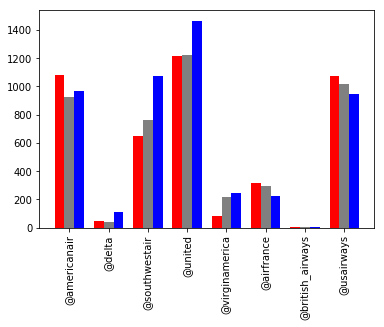

In [29]:
import matplotlib.pyplot as plt
import numpy

for i, r in enumerate(results):
    unique, counts = numpy.unique(r, return_counts=True)
    for u, c in zip(unique, counts):
        if u == 0:
            plt.bar(i - 0.25, c, 0.25, color="red")
        if u == 1:
            plt.bar(i, c, 0.25, color="grey")
        if u == 2:
            plt.bar(i + 0.25, c, 0.25, color="blue")

plt.xticks(list(range(len(airline_names))))
plt.gca().set_xticklabels(airline_names)
plt.xticks(rotation=90)
plt.show()


For a company, this bar chart gives a first idea of their reputation on social network, and if customers are generally satisfied or not, comparing with competing companies.

Especially, we can see with this analysis that American Airlines and US Airways are the two companies that have more negative tweets than positive and neutral.  

## 3.3 - Term Analysis

POS-tagging consists of extracting the part-of-speech (POS) of each token in a sentence. For instance, the table below depicts the part-of-speechs of the sentence *The cat is white!* are.



|   The   | cat  |  is  | white     |    !       |
|---------|------|------|-----------|------------|
| article | noun | verb | adjective | punctation |


The part-of-speech can be more complex than what we have learned in the school. Linguistics need to have a more detailed information about systax information of the words in a sentence. For our problem, we do not need this level of information and, thus, we will use a less complex set, called universal POS tags. 

In POS-tagging, each part-of-speech is represented by a tag. You can find the POS tag list used in this assignement at https://universaldependencies.org/u/pos/ .

In [30]:
# NLTK POS-tagger

import nltk


#before using pos_tag function, you have to tokenize the sentence.
s = ['The', 'cat', 'is',  'white', '!']
nltk.pos_tag(s,tagset='universal')


[('The', 'DET'), ('cat', 'NOUN'), ('is', 'VERB'), ('white', 'ADJ'), ('!', '.')]

### 3.3.1 Question 12 (2 points)

**Implement a code** that retrieves the top 10 most frequent terms for each airline company. You will only consider the terms that appear in a positive and negative tweets. Besides that, we consider as term:
1. Words that are either an adjective or a noun
2. n-grams that are composed by adjectives followed by a noun (e.g., dirty place) or a noun followed by another noun (e.g.,sports club).

Moreover, **generate a table** with the top 10 most frequent terms and their normalized frequencies(percentage) for each airline company.

**Do not forget to remove the company names from the chart.**

In [31]:
data_without_neutral = []

airline_names = [
    "@americanair", "#americanair", "american air", "american_air", "@delta",
    "#delta", "delta air", "delta_air", "@southwestair", "#southwestair",
    "southwest air", "southwest_air", "@united", "#united", "united air",
    "united_air", "@virginamerica", "#virginamerica", "virgin america",
    "virgin_america", "@airfrance", "#airfrance", "air france", "air_france",
    "@british_airways", "#british_airways", "british air", "@usairways",
    "#usairways", "us air", "us_air"
]

pipeline = PreprocessingPipeline(
    tokenization=True, twitterPreprocessing=False, stemming=True)

for tweets, sentiments in zip(data, results):
    tweets_without_neutral = []
    process_tweets = map(pipeline.preprocess, tweets)
    for tweet, sentiment in zip(process_tweets, sentiments):
        if sentiment != 1:
            new_tweet = [
                word for word in tweet
                if not any(word in name for name in airline_names)
            ]
            tweets_without_neutral.append(new_tweet)
    data_without_neutral.append(tweets_without_neutral)


In [32]:
print(*data_without_neutral[0][:2], sep="\n")


['@dfwairport', 'have', 'been', 'tri', 'to', 'get', 'canx', 'flight', 'resch', 'sinc', 'noon', '.', 'got', '2', 'call', 'back', 'but', 'call', 'disconnect', 'as', 'soon', 'as', 'answer']
['after', 'all', ',', 'the', 'plane', "didn't", 'land', 'ident', 'or', 'wors', ')', 'condit', 'at', 'grk', 'accord', 'to', 'metar', '.']


In [33]:
def pos_processing(tweet):
    new_tweet = []

    authorized = [
        # unigram
        "NOUN",
        "ADJ",
        #bigram
        ('ADJ', 'NOUN'),
        ('ADJ', 'NOUN'),
        ('NOUN', 'NOUN'),
        #trigram
        ('ADJ', 'NOUN', 'NOUN'),
        ('NOUN', 'NOUN', 'NOUN'),
        ('ADJ', 'ADJ', 'NOUN'),
        ('NOUN', 'ADJ', 'NOUN')
    ]

    for word, tag in nltk.pos_tag(tweet, tagset='universal'):
        if tag in authorized:
            new_tweet.append(word)

    for i in range(len(tweet) - 1):
        pos_bigram = list(
            zip(*nltk.pos_tag(tweet[i:i + 2], tagset='universal')))
        if pos_bigram[1] in authorized:
            new_tweet.append(' '.join(pos_bigram[0]))

    for i in range(len(tweet) - 2):
        pos_bigram = list(
            zip(*nltk.pos_tag(tweet[i:i + 3], tagset='universal')))
        if pos_bigram[1] in authorized:
            new_tweet.append(' '.join(pos_bigram[0]))
    return new_tweet


In [34]:
# data with only authorized data type
data_only_auth = [list(map(pos_processing, d)) for d in data_without_neutral]


In [35]:
print(*data_only_auth[0][:2], sep="\n")


['@dfwairport', 'canx', 'flight', 'resch', 'sinc', 'noon', 'call', 'disconnect', 'answer', 'canx flight', 'flight resch', 'resch sinc', 'sinc noon', 'call disconnect', 'canx flight resch', 'flight resch sinc', 'resch sinc noon']
['plane', "didn't", 'land', 'ident', 'wors', 'condit', 'grk', 'accord', "plane didn't", "didn't land", 'land ident', 'grk accord', "plane didn't land"]


In [36]:
# note that didn is considered a noun!
print(*nltk.pos_tag(["i", "didn't"], tagset='universal'), sep="\n")


('i', 'NOUN')
("didn't", 'NOUN')


In [37]:
import numpy as np


def n_frequent(tweets):
    flat_tweets = [word for tweet in tweets for word in tweet]
    vocab, counts = np.unique(flat_tweets, return_counts=True)
    counts_vocab = sorted(zip(counts, vocab), reverse=True)
    return counts_vocab[:10]


In [38]:
airline_names = [
    "American Air", "Delta", "Southwest Air", "United", "Virgin America",
    "Air France", "British Airways", "US Airways"
]

for data_airline, airline in zip(data_only_auth, airline_names):
    print("-" * 10 + "{:^20s}".format(airline) + "-" * 10)
    for c, w in n_frequent(data_airline):
        print("\t{:20s}:{:5d}".format(w, c))


----------    American Air    ----------
	flight              :  792
	thank               :  295
	cancel              :  237
	servic              :  164
	custom              :  164
	cancel flightl      :  162
	flightl             :  150
	hour                :  134
	"                   :  128
	cancel flight       :  126
----------       Delta        ----------
	@delta_goodrem      :   36
	flight              :   28
	i'm                 :   15
	time                :   13
	good                :   12
	thank               :    9
	custom              :    9
	sorri               :    8
	new                 :    8
	cancel              :    8
----------   Southwest Air    ----------
	flight              :  647
	thank               :  307
	cancel              :  176
	time                :  108
	servic              :  108
	custom              :  105
	cancel flightl      :  104
	cancel flight       :   97
	hour                :   89
	hold                :   88
----------       United       -------

### 3.3.2 Question 13 (1 point)

The table generated in the Question 12 can lead us to any conclusion about each one of the 9 companies? Can we identify specific events that have occured during the data retrieval?

* Air France, "sad", "miss", and "crash" must refer to the accident that occured in 2009.

* Delta, we have some fake positive when we detect the company, due to the artist Delta Goodrem.

* Every company has a lot of "cancel" or "cancel flight" which makes sense (you *usually* tweet when you are disappointed about a service)

# 4 - Bonus (2 points)

Person names, companies names and locations are called named entities. Named-entity recognition (NER) is the task of extracting named entities  classifying them using pre-defined categories. In this bonus section, you will use a Named Entity Recognizer to automatically extract named entities from the tweets. This approach is generic enough to retrieve information about other companies or even product and people names.

**For the bonus, you are free to use any Named Entity Recognizer that has python wrapper or is implemented in python. Moreover, you have to use the tweet database of the previous section (https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing)**


## 4.1 - Bonus 2 (1 point)

Implement a code that generates the table with the top 10 most mentioned named entities in the database (this table has to contain the frequencies of the name entities). After that, generates a bar chart that despicts the number of positive, negative and neutral tweets for each one of these 10 named entities. Briefly describe the results found in the bar chart.

*Ignore the named entities related to the following airline companies : Air France, American, British Airways,  Delta, Southwest, United, Us Airways and Virgin America.*

In [39]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/quentin/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/quentin/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [40]:
def get_ne(tweet):
    airline_names = [
    "@americanair", "#americanair", "american air", "american_air", "@delta",
    "#delta", "delta air", "delta_air", "@southwestair", "#southwestair",
    "southwest air", "southwest_air", "@united", "#united", "united air",
    "united_air", "@virginamerica", "#virginamerica", "virgin america",
    "virgin_america", "@airfrance", "#airfrance", "air france", "air_france",
    "@british_airways", "#british_airways", "british air", "@usairways",
    "#usairways", "us air", "us_air"
    ]
    
    tagged_tweet = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(tweet)))
    ne_tag = ["ORGANIZATION", "PERSON", "LOCATION", "FACILITY", "GPE", "GSP"]
    ne = []
    for chunk in tagged_tweet:
        if hasattr(chunk, 'label') and chunk.label() in ne_tag:
            ne.append(' '.join(c[0] for c in chunk if c[0] not in airline_names))
    return ne

In [42]:
name_entity = list(map(get_ne, tweets_list))
entities, counts = np.unique([v for ne in name_entity for v in ne if ne], return_counts=True)
counts_entities = sorted(zip(counts, entities), reverse=True)

In [43]:
for c, e in counts_entities[:10]:
    print("{:20s}: {:10d}".format(e, c))

Good                :       6937
LOL                 :       5470
Sorry               :       5221
Twitter             :       4258
Happy               :       4093
Great               :       3142
iPhone              :       3032
Haha                :       2571
Got                 :       2289
Thanks              :       2125


In [44]:
top10_ne = list(list(zip(*counts_entities[:10]))[1])
tweets_to_classify = [[] for _ in range(10)]

for tweet, ne in zip(tweets_list, name_entity):
    if ne:
        for i, e in enumerate(top10_ne):
            if e in ne:
                tweets_to_classify[i].append(tweet)

In [45]:
bow_to_classify = [bowObj.transform(tweets) for tweets in tweets_to_classify]


In [46]:
results = [extract_sentiment(classifier, bow) for bow in bow_to_classify]


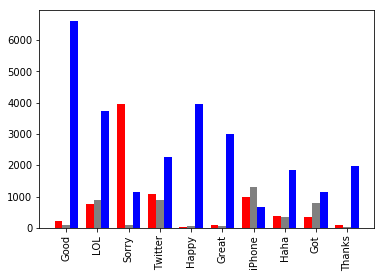

In [47]:
import matplotlib.pyplot as plt
import numpy

for i, r in enumerate(results):
    unique, counts = numpy.unique(r, return_counts=True)
    for u, c in zip(unique, counts):
        if u == 0:
            plt.bar(i - 0.25, c, 0.25, color="red")
        if u == 1:
            plt.bar(i, c, 0.25, color="grey")
        if u == 2:
            plt.bar(i + 0.25, c, 0.25, color="blue")

plt.xticks(list(range(len(top10_ne))))
plt.gca().set_xticklabels(top10_ne)
plt.xticks(rotation=90)
plt.show()

It makes sense that "good" , "happy" and "great" are very positive. Similarly, "Sorry" is very negative. 

## 4.2 - Bonus 3 (1 point)

Generate a similar table produced in the Question 12 for the 10 most mentioned named entities in Bonus 2. Can we draw any conclusion about these named entities?